# Imports

In [0]:
from PIL import Image, ImageDraw
import numpy as np
from sklearn import datasets

# Setup

In [3]:
# Mount CU Drive
from google.colab import drive
drive.mount('/content/drive')

!mkdir drive/My\ Drive/synthetic-ds
!mkdir drive/My\ Drive/synthetic-ds/ct2
!mkdir drive/My\ Drive/synthetic-ds/ctp2
!mkdir drive/My\ Drive/synthetic-ds/squares
!mkdir drive/My\ Drive/synthetic-ds/point
!mkdir drive/My\ Drive/synthetic-ds/point/circles
!mkdir drive/My\ Drive/synthetic-ds/point/s_curves
!mkdir drive/My\ Drive/synthetic-ds/point/swiss_roll

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/ct2’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/ctp2’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/squares’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/point’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/point/circl

# Image Dataset Generation

## Squares

In [0]:
def get_sample(mean, stdev):
    return np.random.multivariate_normal(mean, (stdev**2)*np.identity(2))

def gen_mixture(no_of_dist, dataset_size, scaling_factor = (100, 10)):
    # Generate means and stdev of the mixture
    mean = np.random.rand(no_of_dist, 2)* scaling_factor[0]
    stdev = np.random.rand(no_of_dist)* scaling_factor[1]

    # Generate dataset
    idx = np.random.randint(0, high = no_of_dist, size = dataset_size)
    mean_arr = mean[idx]
    stdev_arr = stdev[idx]

    data = np.zeros((dataset_size, 2))
    for i in range(dataset_size):
        data[i] = get_sample(mean_arr[i], stdev_arr[i])
    
    return idx, data, mean, stdev

# Fixed size of images : 64 x 64 x 1
# For simplicity keep size of squares to be exponents of 2 i.e. 2, 4, 8 ...
def draw_square(im, square_size, im_size, top_left = None):
    if top_left is None:
      top_left = np.random.randint(0, high = im_size - square_size, size = 2)
    
    # Set colour 
    im[top_left[0] : top_left[0] + square_size, top_left[1] : top_left[1] + square_size] = 1

    return im, top_left

def non_overlapping_square(im, no_of_squares, square_size, im_size):
    bad_corners = True
    while bad_corners:
        top_left = np.random.randint(0, high = im_size - square_size - 1, size = (no_of_squares, 2))
        new_im = np.copy(im)
        found_combination = False
        for i in range(0, no_of_squares):
            relevant_square = new_im[top_left[i][0]: top_left[i][0] + square_size, top_left[i][1] : top_left[i][1] + square_size] 
            neighbors = relevant_square[relevant_square == 1]
            if neighbors.shape[0] == 0:
                draw_square(new_im, square_size, im_size, top_left[i])
                if i == no_of_squares - 1:
                    found_combination = True
            else:
                bad_corners = True
                break

        if bad_corners and not found_combination:
            continue
        bad_corners = False
    return new_im



def gen_square_image(no_of_squares, square_size, overlap, im_size):
    im = np.zeros((im_size, im_size))

    idx = []
    if overlap:
        for i in range(no_of_squares):
            im, ind = draw_square(im, square_size, im_size)
            idx.append(ind)
    else:
        im = non_overlapping_square(im, no_of_squares, square_size, im_size)

    return im
  
def gen_square_dataset(no_of_squares, square_size, dataset_size, overlap, im_size = 128):
  ds = np.zeros((dataset_size, im_size, im_size))
  for i in range(dataset_size):
    ds[i] = gen_square_image(no_of_squares, square_size, overlap, im_size)
  return ds

In [0]:
# Save dataset with 1 square of size 32 
ds = gen_square_dataset(1, 32, 5000, False)
np.save("drive/My Drive/synthetic-ds/squares/1-32.npy", ds)

# Save dataset with 4 squares of size 16 
ds = gen_square_dataset(4, 16, 5000, False)
np.save("drive/My Drive/synthetic-ds/squares/4-16.npy", ds)

# Save dataset with 10 squares of size 8 
ds = gen_square_dataset(10, 8, 5000, False)
np.save("drive/My Drive/synthetic-ds/squares/4-16.npy", ds)

# Save dataset with 1 square of size 16 in 28x28
ds = gen_square_dataset(1, 16, 5000, False, im_size = 28)
np.save("drive/My Drive/synthetic-ds/squares/1-16-28x28.npy", ds)

# Save dataset with 3 squares of size 4 
ds = gen_square_dataset(3, 4, 5000, False, im_size = 28)
np.save("drive/My Drive/synthetic-ds/squares/3-4-28x28.npy", ds)

## Mixture of Polygons

### Code

In [0]:
def generate_ct2(im_path, im_size):
  image = Image.new('RGB', (im_size, im_size))
  image.save(im_path, "PNG")
  
  image = Image.open(im_path)
  draw = ImageDraw.Draw(image)

  # Draw 2 circles
  x = np.random.randint(10, high = im_size - 10)
  y = np.random.randint(10, high = im_size - 10)
  r = np.random.randint(min(x, y, im_size - x, im_size - y))
  draw.ellipse((x-r, y-r, x+r, y+r), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  x = np.random.randint(10, high = im_size - 10)
  y = np.random.randint(10, high = im_size - 10)
  r = np.random.randint(min(x, y, im_size - x, im_size - y))
  draw.ellipse((x-r, y-r, x+r, y+r), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  # Draw 2 triangles
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))

  image.save(im_path)
  
def generate_ctp2(im_path, im_size):
  # Create new image (all black)
  image = Image.new('RGB', (im_size, im_size))
  draw = ImageDraw.Draw(image)

  # Draw 2 circles
  x = np.random.randint(10, high = im_size - 10)
  y = np.random.randint(10, high = im_size - 10)
  r = np.random.randint(min(x, y, im_size - x, im_size - y))
  draw.ellipse((x-r, y-r, x+r, y+r), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  x = np.random.randint(10, high = im_size - 10)
  y = np.random.randint(10, high = im_size - 10)
  r = np.random.randint(min(x, y, im_size - x, im_size - y))
  draw.ellipse((x-r, y-r, x+r, y+r), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  # Draw 2 triangles
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  # Draw 2 polygons (4 sided)
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))

  image.save()

def gen_image_dataset(image_name, im_size, dataset_size, image_generator, path):
  im_path = path + image_name
  for i in range(dataset_size):
    image_generator(im_path + str(i) + '.png', im_size)

### Generation

In [0]:
gen_image_dataset('image', 128, 5000, generate_ct2, 'drive/My Drive/synthetic-ds/ct2/')
gen_image_dataset('image', 128, 5000, generate_ctp2, 'drive/My Drive/synthetic-ds/ctp2/')

### Utilites for testing

In [0]:
# Check if the files have been generated 
!ls drive/My\ Drive/synthetic-ds/ct2/
!ls drive/My\ Drive/synthetic-ds/ctp2/

In [0]:
# Delete all files in relevant folders
!rm drive/My\ Drive/synthetic-ds/ct2/*
!rm drive/My\ Drive/synthetic-ds/ctp2/*

rm: cannot remove 'drive/My Drive/synthetic-ds/ctp2/*': No such file or directory


# Point (in $R^n$) Dataset Generation 

## Circles

In [0]:
circle_factor_1 = datasets.make_circles(n_samples = 5000, factor = 0.1, random_state = 0)
circle_factor_5 = datasets.make_circles(n_samples = 5000, factor = 0.5, random_state = 0)
circle_factor_9 = datasets.make_circles(n_samples = 5000, factor = 0.9, random_state = 0)

circle_noise_5 = datasets.make_circles(n_samples = 5000, factor = 0.5, noise = 0.05, random_state = 0)
circle_noise_10 = datasets.make_circles(n_samples = 5000, factor = 0.5, noise = 0.1, random_state = 0)
circle_noise_50 = datasets.make_circles(n_samples = 5000, factor = 0.5, noise = 0.5, random_state = 0)

In [0]:
np.save('drive/My Drive/synthetic-ds/point/circles/circle_factor_1', np.column_stack((circle_factor_1[0], circle_factor_1[1])))
np.save('drive/My Drive/synthetic-ds/point/circles/circle_factor_5', np.column_stack((circle_factor_5[0], circle_factor_5[1])))
np.save('drive/My Drive/synthetic-ds/point/circles/circle_factor_9', np.column_stack((circle_factor_9[0], circle_factor_9[1])))

np.save('drive/My Drive/synthetic-ds/point/circles/circle_noise_5', np.column_stack((circle_noise_5[0], circle_noise_5[1])))
np.save('drive/My Drive/synthetic-ds/point/circles/circle_noise_10', np.column_stack((circle_noise_10[0], circle_noise_10[1])))
np.save('drive/My Drive/synthetic-ds/point/circles/circle_noise_50', np.column_stack((circle_noise_50[0], circle_noise_50[1])))

## S Curve

In [0]:
scurve_noise_5 = datasets.make_s_curve(n_samples = 5000, noise = 0.05, random_state = 0)
scurve_noise_10 = datasets.make_s_curve(n_samples = 5000, noise = 0.1, random_state = 0)
scurve_noise_50 = datasets.make_s_curve(n_samples = 5000, noise = 0.5, random_state = 0)

In [0]:
np.save('drive/My Drive/synthetic-ds/point/s_curves/scurve_noise_5', np.column_stack((scurve_noise_5[0], scurve_noise_5[1])))
np.save('drive/My Drive/synthetic-ds/point/s_curves/scurve_noise_10', np.column_stack((scurve_noise_10[0], scurve_noise_10[1])))
np.save('drive/My Drive/synthetic-ds/point/s_curves/scurve_noise_50', np.column_stack((scurve_noise_50[0], scurve_noise_50[1])))

## Swiss Roll

In [0]:
roll_noise_5 = datasets.make_swiss_roll(n_samples = 5000, noise = 0.05, random_state = 0)
roll_noise_10 = datasets.make_swiss_roll(n_samples = 5000, noise = 0.1, random_state = 0)
roll_noise_50 = datasets.make_swiss_roll(n_samples = 5000, noise = 0.5, random_state = 0)

In [0]:
np.save('drive/My Drive/synthetic-ds/point/swiss_roll/roll_noise_5', np.column_stack((roll_noise_5[0], roll_noise_5[1])))
np.save('drive/My Drive/synthetic-ds/point/swiss_roll/roll_noise_10', np.column_stack((roll_noise_10[0], roll_noise_10[1])))
np.save('drive/My Drive/synthetic-ds/point/swiss_roll/roll_noise_50', np.column_stack((roll_noise_50[0], roll_noise_50[1])))

## Clusters

In [23]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        '''
        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        '''
        
        X_train = np.load('drive/My Drive/synthetic-ds/squares/3-4-28x28.npy')
        X_train = X_train/0.5 - 1
        X_train = np.expand_dims(X_train, axis=3)
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            
            if epoch%1000 == 0:
              # Plot the progress
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=50000, batch_size=32, save_interval=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.812578, acc.: 50.00%] [G loss: 1.286517]
1000 [D loss: 0.075364, acc.: 100.00%] [G loss: 4.467171]
2000 [D loss: 0.033199, acc.: 100.00%] [G loss: 7.412024]
3000 [D loss: 0.006304, acc.: 100.00%] [G loss: 3.813706]
4000 [D loss: 0.001380, acc.: 100.00%] [G loss: 4.733938]
5000 [D loss: 0.006297, acc.: 100.00%] [G loss: 6.355708]
6000 [D loss: 0.007080, acc.: 100.00%] [G loss: 6.586244]
7000 [D loss: 0.017485, acc.: 100.00%] [G loss: 5.832703]
8000 [D loss: 0.003328, acc.: 100.00%] [G loss: 10.219748]
9000 [D loss: 0.003177, acc.: 100.00%] [G loss: 9.702475]
10000 [D loss: 0.005199, acc.: 100.00%] [G loss: 7.684543]
11000 [D loss: 0.002948, acc.: 100.00%] [G loss: 7.958046]
12000 [D loss: 0.020107, acc.: 98.44%] [G loss: 8.736135]
13000 [D loss: 0.008956, acc.: 100.00%] [G loss: 8.885269]
14000 [D loss: 0.005505, acc.: 100.00%] [G loss: 10.842485]
15000 [D loss: 0.014455, acc.: 100.00%] [G loss: 6.363183]
16000 [D loss: 0.001464, acc.: 100.00%] [G loss: 11.614381]
17000 [D 

In [0]:
!rm images/*

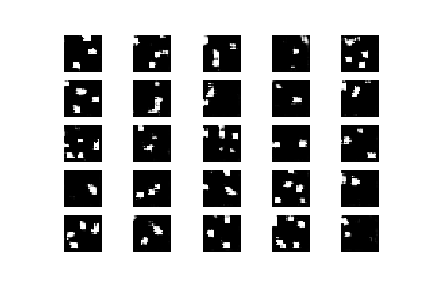

In [24]:
from IPython.display import Image
Image(filename='images/mnist_1000.png')

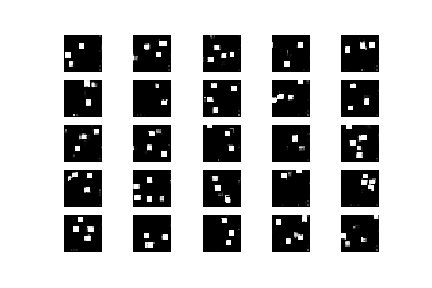

In [28]:
from IPython.display import Image
Image(filename='images/mnist_49000.png')